In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrix
from sklearn.metrics import mean_squared_error
from pyearth import Earth
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, \
roc_curve, auc, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier

from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier

## Data Cleaning

In [4]:
data = pd.read_csv('boston.csv')
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [3]:
# number of na values
data.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [6]:
# changing column names to make interpretation easier
data.columns = ['crime_rate', 'zoned_land', 'nr_business', 'river', 'nitric_oxide', 'avg_rooms', 'prop_age', 
                'dist_emp', 'highway_acc', 'tax_rate', 'pt_ratio', 'race_prop', 'low_inc', 'median_val']
data.head()

,crime_rate,zoned_land,nr_business,river,nitric_oxide,avg_rooms,prop_age,dist_emp,highway_acc,tax_rate,pt_ratio,race_prop,low_inc,median_val
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [5]:
# data types
data.dtypes

crime_rate      float64
zoned_land      float64
nr_business     float64
river             int64
nitric_oxide    float64
avg_rooms       float64
prop_age        float64
dist_emp        float64
highway_acc       int64
tax_rate        float64
pt_ratio        float64
race_prop       float64
low_inc         float64
median_val      float64
dtype: object

## EDA

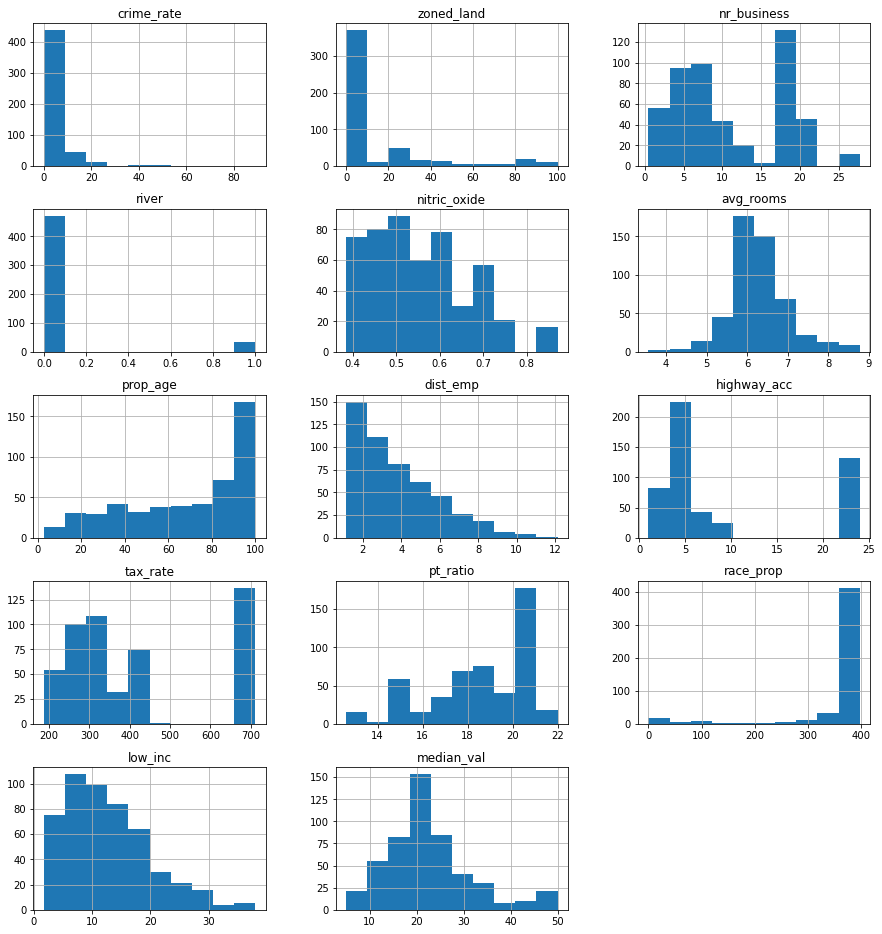

In [6]:
# creating a histogram to view distribution of each feature
data.hist(figsize=(15,30),layout=(9,3));

In [7]:
print(data.columns)

Index(['crime_rate', 'zoned_land', 'nr_business', 'river', 'nitric_oxide',
       'avg_rooms', 'prop_age', 'dist_emp', 'highway_acc', 'tax_rate',
       'pt_ratio', 'race_prop', 'low_inc', 'median_val'],
      dtype='object')


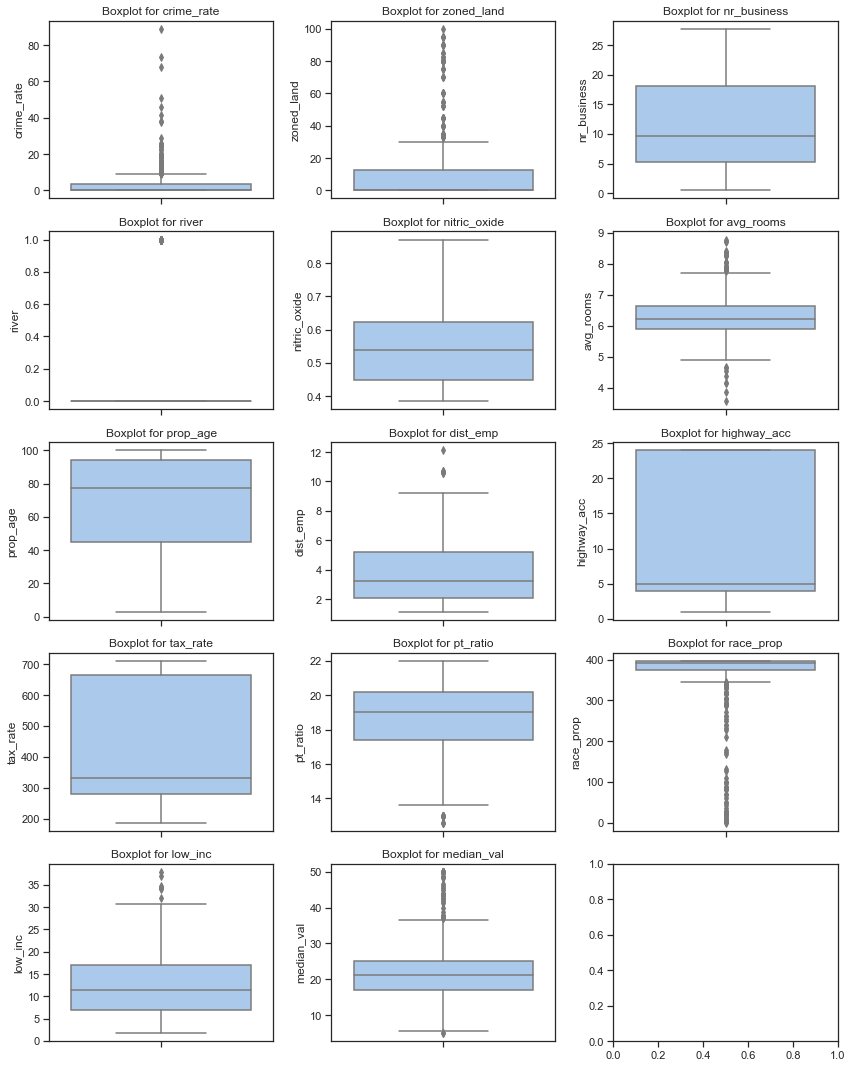

In [8]:
# boxplot to see distribution 
sns.set(style="ticks", palette="pastel")

columns = ['crime_rate', 'zoned_land', 'nr_business', 'river', 'nitric_oxide',
           'avg_rooms', 'prop_age', 'dist_emp', 'highway_acc', 'tax_rate',
           'pt_ratio', 'race_prop', 'low_inc', 'median_val']

#data = pd.read_csv('your_data_file.csv')

fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(12, 15))
axs = axs.flatten()

for i, col in enumerate(columns):
    sns.boxplot(y=data[col], ax=axs[i])
    axs[i].set_title(f'Boxplot for {col}')

plt.tight_layout()
plt.show()

In [9]:
# finding outliers and influential points
# VIF to detect multicollinearity
X = data[columns]

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Check for missing values and convert data to numeric type
X = X.apply(pd.to_numeric, errors='coerce')

# Drop rows with missing values
X = X.dropna()

X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

print(vif_data)

         feature         VIF
0          const  645.977937
1     crime_rate    1.831537
2     zoned_land    2.352186
3    nr_business    3.992503
4          river    1.095223
5   nitric_oxide    4.586920
6      avg_rooms    2.260374
7       prop_age    3.100843
8       dist_emp    4.396007
9    highway_acc    7.808198
10      tax_rate    9.205542
11      pt_ratio    1.993016
12     race_prop    1.381463
13       low_inc    3.581585
14    median_val    3.855684


Using random.seed() / random_state equal to 45 to have reproducible results

Current model split: 
- Ava: random forest
- Avanti: MARS & bagging MARS
- Emily: Lasso & Ridge
- Ada: Decision Trees & Bagging

# Modeling

## MARS Models
*By: Avanti Parkhe*

In [7]:
data.head()

,crime_rate,zoned_land,nr_business,river,nitric_oxide,avg_rooms,prop_age,dist_emp,highway_acc,tax_rate,pt_ratio,race_prop,low_inc,median_val
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [8]:
# splitting data into train and test
y = data.median_val
X = data.drop('median_val', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 45)

In [10]:
# finding the optimal degree of the MARS model
degrees = range(1, 5)
cv = KFold(n_splits=5, random_state=1, shuffle=True)

mse_list = []

for degree in degrees:
    model = Earth(max_terms = 1000, max_degree=degree)

    mse = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()

    mse_list.append(mse)

optimal_degree = degrees[mse_list.index(min(mse_list))]

/Users/avantiparkhe/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/avantiparkhe/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/Users/avantiparkhe/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` w

/Users/avantiparkhe/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/Users/avantiparkhe/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/avantiparkhe/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` 

In [11]:
optimal_degree

1

In [12]:
model = Earth(max_terms=500, max_degree=optimal_degree, feature_importance_type= 'rss')
model.fit(X_train,y_train)
print(model.summary())

Earth Model
--------------------------------------------
Basis Function         Pruned  Coefficient  
--------------------------------------------
(Intercept)            No      -71.2171     
h(low_inc-6.36)        No      -0.50335     
h(6.36-low_inc)        No      1.91635      
h(avg_rooms-6.437)     Yes     None         
h(6.437-avg_rooms)     No      7.33402      
h(dist_emp-1.4165)     No      56.1458      
h(1.4165-dist_emp)     Yes     None         
h(crime_rate-17.8667)  Yes     None         
h(17.8667-crime_rate)  No      0.622457     
pt_ratio               No      -0.687985    
nitric_oxide           No      -18.3959     
highway_acc            No      0.424652     
tax_rate               No      -0.0130832   
h(dist_emp-3.7598)     No      -56.8048     
h(3.7598-dist_emp)     No      58.4661      
h(avg_rooms-7.923)     Yes     None         
h(7.923-avg_rooms)     No      -28.5086     
h(avg_rooms-7.313)     Yes     None         
h(7.313-avg_rooms)     No      21.4854     

/Users/avantiparkhe/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/avantiparkhe/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


In [13]:
# finding feature importance
model = Earth(max_terms=500, max_degree=optimal_degree, feature_importance_type = 'rss')
model.fit(X_train, y_train)
importance = model.feature_importances_
importance_df = pd.DataFrame({'Predictor': X.columns, 'Importance': importance})
importance_df = importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)
print(importance_df)

       Predictor  Importance
0        low_inc    0.585254
1      avg_rooms    0.297714
2       dist_emp    0.041965
3     crime_rate    0.031766
4       pt_ratio    0.011012
5    highway_acc    0.010645
6   nitric_oxide    0.009126
7       tax_rate    0.008765
8      race_prop    0.003130
9          river    0.000621
10    zoned_land    0.000000
11   nr_business    0.000000
12      prop_age    0.000000


/Users/avantiparkhe/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/avantiparkhe/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


In [14]:
# computing RMSE on test data
pred = model.predict(X_test)
np.sqrt(mean_squared_error(pred, y_test))

3.6362683604822763

Currently on the naive model, we found that the RMSE on test data was 5.214447779533273. This RMSE from the MARS model is lower at 3.6362683604822763. 

## Bagging MARS Models
*By: Avanti Parkhe*

In [15]:
# taking the average of 10 models
models = []
preds = []

for i in range(10):
    sample = X_train.sample(n=len(X_train), replace=True, random_state=i)
    y_sample = y_train.loc[sample.index]
    
    # fitting model
    model = Earth(max_degree = optimal_degree)
    model.fit(sample, y_sample)
    models.append(model)
    
    pred = model.predict(X_test)
    preds.append(pred)

avg_pred = np.mean(preds, axis=0)

/Users/avantiparkhe/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/avantiparkhe/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/Users/avantiparkhe/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` w

In [16]:
np.sqrt(mean_squared_error(avg_pred, y_test))

3.579691272860141

This RMSE is lower than the RMSE of the unbagged MARS model. 

In [17]:
# taking the average of 50 models
models = []
preds = []

for i in range(50):
    sample = X_train.sample(n=len(X_train), replace=True, random_state=i)
    y_sample = y_train.loc[sample.index]
    
    # fitting model
    model = Earth(max_degree = optimal_degree)
    model.fit(sample, y_sample)
    models.append(model)
    
    pred = model.predict(X_test)
    preds.append(pred)

avg_pred = np.mean(preds, axis=0)

/Users/avantiparkhe/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/avantiparkhe/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/Users/avantiparkhe/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` w

/Users/avantiparkhe/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/Users/avantiparkhe/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/avantiparkhe/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` 

/Users/avantiparkhe/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/Users/avantiparkhe/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/avantiparkhe/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` 

/Users/avantiparkhe/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/Users/avantiparkhe/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/avantiparkhe/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` 

/Users/avantiparkhe/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/Users/avantiparkhe/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/avantiparkhe/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` 

In [19]:
np.sqrt(mean_squared_error(avg_pred, y_test))

3.525044668657741

This RMSE is lower than the RMSE of the 10 bagged models but not significantly lower. 

Our final RMSE for the bagged MARS models is 3.525044668657741

## Random Forest
*By: Ava Serin*

In [21]:
# First using RandomizedSearchCV
# Define hyperparameter grid
param_distributions = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [10, 20, 30, 40],
    'max_features': [1.0, 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_model = RandomForestRegressor(random_state=45)

cv = KFold(n_splits=5, shuffle=True, random_state=45)

random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_distributions,
    n_iter=100,  # number of random parameter combinations to try
    cv=cv,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    random_state=45
)

random_search.fit(X_train, y_train)
print("Best hyperparameters:", random_search.best_params_)
print()
best_model = random_search.best_estimator_
y_test_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("Test RMSE:", test_rmse)

Best hyperparameters: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}

Test RMSE: 2.9490771849917916


In [22]:
# Train with results from RandomizedCV

# Define hyperparameter grid
param_grid = {
    'n_estimators': [800, 1000, 1200],
    'max_depth': [20, 30, 40],
    'max_features': ['sqrt'],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'bootstrap': [False]
}


# Create random forest model
rf_model = RandomForestRegressor(random_state=45)

# KFold cross validation object
cv = KFold(n_splits = 5,shuffle=True,random_state=45)

# Create grid search object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=cv, n_jobs=-1, 
                           scoring='neg_mean_squared_error', verbose = 2)

# Fit grid search object to training data
grid_search.fit(X_train, y_train)

# Print best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Compute RMSE on test data using best model from grid search
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("Test RMSE:", test_rmse)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   1.3s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1200; total time=   1.9s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1000; total time=   1.5s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1200; total time=   1.8s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1000; total time=   1.4s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=   1.3s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators

/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   1.6s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1200; total time=   2.0s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1000; total time=   1.5s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=800; total time=   1.2s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1000; total time=   1.5s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=   1.4s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=   1.7s
[CV] END bootstrap=False, max_depth=

In [23]:
# Train with a slightly finer grid

# Define hyperparameter grid
param_grid = {
    'n_estimators': [1100, 1200, 1300],
    'max_depth': [15, 20, 25],
    'max_features': ['sqrt'],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'bootstrap': [False]
}


# Create random forest model
rf_model = RandomForestRegressor(random_state=45)

# KFold cross validation object
cv = KFold(n_splits = 5,shuffle=True,random_state=45)

# Create grid search object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=cv, n_jobs=-1, 
                           scoring='neg_mean_squared_error', verbose = 2)

# Fit grid search object to training data
grid_search.fit(X_train, y_train)

# Print best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Compute RMSE on test data using best model from grid search
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("Test RMSE:", test_rmse)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best hyperparameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1100}
Test RMSE: 2.924900376975113


In [8]:
# Train final random forest model

rf_model = RandomForestRegressor(
    n_estimators=1100,
    max_depth=20,
    max_features='sqrt',
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=False,
    random_state=45
)
rf_model.fit(X_train, y_train)
y_test_pred = rf_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("Test RMSE:", test_rmse)


Test RMSE: 2.924900376975113


In [9]:
# Feature importances

# Obtain feature importances from the Gradient Boost model
importances = rf_model.feature_importances_

# Create a dataframe with predictor names and their importances
importance_df = pd.DataFrame({'Predictor': X_train.columns, 'Importance': importances})

# Sort the dataframe by importances in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the sorted dataframe
importance_df

,Predictor,Importance
12,low_inc,0.269925
5,avg_rooms,0.242134
4,nitric_oxide,0.082395
2,nr_business,0.072949
10,pt_ratio,0.068858
7,dist_emp,0.067707
0,crime_rate,0.064467
9,tax_rate,0.036721
6,prop_age,0.030921
11,race_prop,0.027908


## Decision Tree Models
*By: Ada Zhong*

In [57]:
dt = DecisionTreeRegressor(random_state=45) 
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
print('Untuned decision tree RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

# Find minimum/maximum possible values
print("Maximum tree depth =", dt.get_depth())
print("Maximum leaves =", dt.get_n_leaves())
print("Minimum samples at leaf =", dt.get_params())

Untuned decision tree RMSE: 4.027905114056578
Maximum tree depth = 18
Maximum leaves = 384
Minimum samples at leaf = {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 45, 'splitter': 'best'}


In [71]:
# Coarse grid search
# Finding cross-validation error for trees 
parameters = {'max_depth':range(2, 19, 2),
              'max_leaf_nodes':range(2, 385, 50),
              'min_samples_leaf':range(1, 5),
              'max_features': [1.0, 'sqrt', 'log2'],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'min_weight_fraction_leaf': np.arange(0,0.5,0.1)
             }

cv = KFold(n_splits=5, shuffle=True, random_state=1)

grid_dt = GridSearchCV(dt, parameters, n_jobs=-1,verbose=1,cv=cv, scoring=['neg_mean_absolute_error', 'r2'], refit='neg_mean_absolute_error')
grid_dt.fit(X_train, y_train)

print(grid_dt.best_score_, grid_dt.best_params_) 

Fitting 5 folds for each of 9720 candidates, totalling 48600 fits
-2.6959621611152214 {'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': 52, 'min_samples_leaf': 2, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0}


In [72]:
# Store cross-validation results
cv_results = pd.DataFrame(grid_dt.cv_results_)

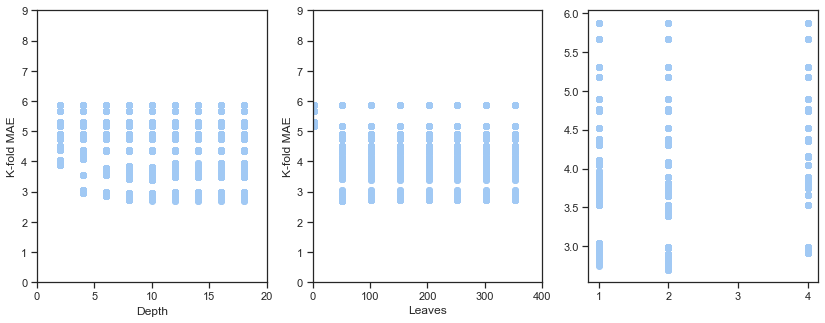

In [73]:
# Detailed results of k-fold cross validation
fig, axes = plt.subplots(1,3,figsize=(14,5))
plt.subplots_adjust(wspace=0.2)
axes[0].plot(cv_results.param_max_depth, -cv_results.mean_test_neg_mean_absolute_error, 'o')
axes[0].set_ylim([0, 9]) 
axes[0].set_xlim([0, 20]) 
axes[0].set_xlabel('Depth')
axes[0].set_ylabel('K-fold MAE')
axes[1].plot(cv_results.param_max_leaf_nodes, -cv_results.mean_test_neg_mean_absolute_error, 'o')
axes[1].set_ylim([0, 9])
axes[1].set_xlim([0, 400]) 
axes[1].set_xlabel('Leaves')
axes[1].set_ylabel('K-fold MAE')
axes[2].plot(cv_results.param_min_samples_leaf, -cv_results.mean_test_neg_mean_absolute_error, 'o')

In [74]:
# Fine grid search
# Finding cross-validation error for trees 

parameters = {'max_depth':range(2, 19, 2),
              'max_leaf_nodes':range(2, 100),
              'min_samples_leaf':range(1, 5),
              'max_features': [1.0, 'sqrt', 'log2'],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'min_weight_fraction_leaf': np.arange(0,0.5,0.1)
             }
cv = KFold(n_splits=5, shuffle=True, random_state=1)

grid_dt = GridSearchCV(dt, parameters, n_jobs=-1,verbose=1,cv=cv, scoring=['neg_mean_absolute_error', 'r2'], refit='neg_mean_absolute_error')
grid_dt.fit(X_train, y_train)

print(grid_dt.best_score_, grid_dt.best_params_) 

Fitting 5 folds for each of 119070 candidates, totalling 595350 fits
-2.6861490720387344 {'max_depth': 12, 'max_features': 1.0, 'max_leaf_nodes': 55, 'min_samples_leaf': 2, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0}


In [75]:
dt_tuned = DecisionTreeRegressor(random_state=45, max_depth=12, max_leaf_nodes=55, min_samples_leaf=2, max_features=1.0, min_samples_split=10, min_weight_fraction_leaf=0.0) 
dt_tuned.fit(X_train, y_train)

y_pred = dt_tuned.predict(X_test)
print('Tuned decision tree RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

# Tuning the decision tree did not improve the RMSE, so I will just use dt for bagging

Tuned decision tree RMSE: 4.044297510430165


## Bagged Trees

In [77]:
bagged_trees = BaggingRegressor(dt, random_state=45).fit(X_train, y_train)

y_pred_bagged = bagged_trees.predict(X_test)

print(f'Bagged trees RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_bagged))}')

Bagged trees RMSE: 3.401164160557209


In [82]:
print(bagged_trees.get_params)

<bound method BaseEstimator.get_params of BaggingRegressor(base_estimator=DecisionTreeRegressor(random_state=45),
                 random_state=45)>


In [80]:
params = {'base_estimator': [dt],
          'max_samples': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
          'max_features': [0.3, 0.5, 0.7, 1.0],
          'bootstrap': [True, False],
          'bootstrap_features': [True, False]}

cv = KFold(n_splits=5, shuffle=True, random_state=45)

bagging_regressor_grid = GridSearchCV(bagged_trees, 
                                      param_grid=params, cv=cv, n_jobs=-1, verbose=1,
                                      scoring = 'neg_mean_absolute_error')
                             
bagging_regressor_grid.fit(X_train, y_train)
print(bagging_regressor_grid.best_score_, bagging_regressor_grid.best_params_) 

Fitting 5 folds for each of 96 candidates, totalling 480 fits
-2.3567311728395057 {'base_estimator': DecisionTreeRegressor(random_state=45), 'bootstrap': False, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 0.8}


In [81]:
best_br_model = BaggingRegressor(base_estimator=dt, 
                                 random_state=45, 
                                 n_jobs=-1, 
                                 n_estimators=150,
                                 max_features=1.0, 
                                 max_samples=0.8,
                                 bootstrap=False, 
                                 bootstrap_features=False)


best_br_model.fit(X_train, y_train)
y_pred_bagged = best_br_model.predict(X_test)

print(f'Tuned bagged trees RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_bagged))}')

Tuned bagged trees RMSE: 3.1731616639455624


The RMSE from tuned bagged decision trees is lower than bagged MARS models, but higher than Random Forest.

# Ridge, Lasso, Stepwise
*By Emily Zhang*

In [4]:
# split data into train and test
np.random.seed(2)
train = data.sample(round(data.shape[0]*0.8)) # 80% of data in training set
test = data.drop(train.index)

### Ridge

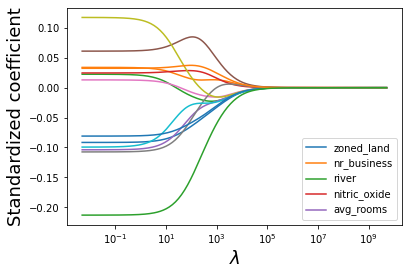

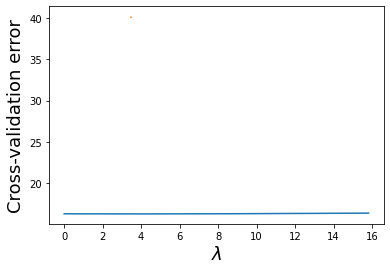

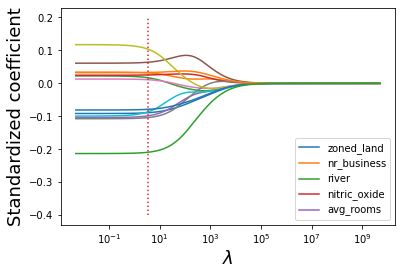

RMSE Ridge: 3.2744798634008294
Ridge coef: [-0.08918515  0.03162475  0.01700329  0.02538032 -0.09862914  0.06401858
  0.01102414 -0.10396571  0.10370713 -0.08653053 -0.07895877  0.03298307
 -0.2092435 ]


In [18]:
#Taking the log transform 
y = np.log(train.median_val)

#Standardizing predictors so that each of them have zero mean and unit variance

#Filtering all predictors
excluded_cols = ['median_val']
selected_cols = [col for col in train.columns if col not in excluded_cols]
X = train[selected_cols] 

scaler = StandardScaler()
scaler.fit(X)
Xstd = scaler.transform(X)

# Optimizing the tuning parameter lambda
alphas = 10**np.linspace(10,-2,200)*0.5

#Finding the ridge regression coefficients for increasing values of the tuning parameter
coefs = []
for a in alphas:        
    ridge = Ridge(alpha = a)
    ridge.fit(Xstd, y)
    coefs.append(ridge.coef_)
    
#Visualizing the shrinkage in ridge regression coefficients with increasing values of the tuning parameter lambda
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train.columns[1:6]);
plt.show()

#Let us use cross validation to find the optimal value of the tuning parameter - lambda
#For the optimal lambda, the cross validation error will be the least

#Note that we are reducing the range of alpha so as to better visualize the minimum
alphas = 10**np.linspace(1.5,-3,200)*0.5
ridgecv = RidgeCV(alphas = alphas,store_cv_values=True)
ridgecv.fit(Xstd, y)

#Optimal value of the tuning parameter - lambda
ridgecv.alpha_

#Visualizing the LOOCV (leave one out cross validatation error vs lambda)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(ridgecv.alphas,ridgecv.cv_values_.sum(axis=0))
plt.plot([ridgecv.alpha_,ridgecv.alpha_],[40,40.2],':')
plt.xlabel('$\lambda$')
plt.ylabel('Cross-validation error')
plt.show()

#Visualizing the shrinkage in ridge regression coefficients with increasing values of the tuning parameter lambda
alphas = 10**np.linspace(10,-2,200)*0.5
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.plot([ridgecv.alpha_,ridgecv.alpha_],[-0.4,0.2],':')
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train.columns[1:6]);
plt.show()

#Test dataset
Xtest = test[selected_cols]

#Standardizing test data
Xtest_std = scaler.transform(Xtest)

#Using the developed ridge regression model to predict on test data
ridge = Ridge(alpha = ridgecv.alpha_)
ridge.fit(Xstd, y)
pred=ridge.predict(Xtest_std)

#RMSE on test data
print('RMSE Ridge:', np.sqrt(((np.exp(pred)-test.median_val)**2).mean()))

#Checking the coefficients of the ridge regression model
print('Ridge coef:', ridge.coef_)

### Lasso

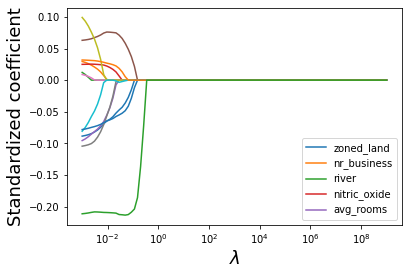

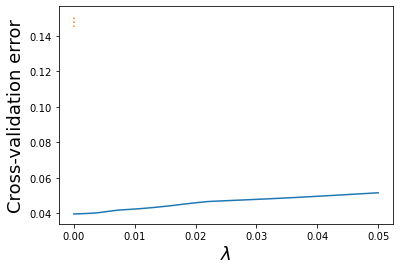

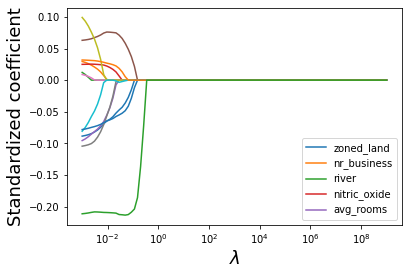

Lasso RMSE: 3.2801703532207425
Lasso coef: [-0.09154541  0.03393505  0.0224902   0.02462967 -0.10381835  0.06114907
  0.01301798 -0.10740441  0.11741107 -0.09925511 -0.08091326  0.03242871
 -0.21309302]


In [17]:
y = np.log(train.median_val)

#Creating a range of values of the tuning parameter to visualize the lasso coefficients
#for different values of the tuning parameter
alphas = 10**np.linspace(10,-2,100)*0.1

#Finding the lasso coefficients for increasing values of the tuning parameter
lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(Xstd, y)
    coefs.append(lasso.coef_)
    
#Visualizing the shrinkage in lasso coefficients with increasing values of the tuning parameter lambda
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train.columns[1:6]);
plt.show()

#Let us use cross validation to find the optimal value of the tuning parameter - lambda
#For the optimal lambda, the cross validation error will be the least

#Note that we are reducing the range of alpha so as to better visualize the minimum
alphas = 10**np.linspace(-1,-5,200)*0.5
lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000)
lassocv.fit(Xstd, y)

#Optimal value of the tuning parameter - lamda
lassocv.alpha_

#Visualizing the LOOCV (leave one out cross validatation error vs lambda)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(lassocv.alphas_,lassocv.mse_path_.mean(axis=1))
plt.plot([lassocv.alpha_,lassocv.alpha_],[0.145,0.151],':')
plt.xlabel('$\lambda$')
plt.ylabel('Cross-validation error')
plt.show()

#Visualizing the shrinkage in lasso coefficients with increasing values of the tuning parameter lambda
alphas = 10**np.linspace(10,-2,100)*0.1
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train.columns[1:6]);
plt.show()

#Using the developed lasso model to predict on test data
lasso = Lasso(alpha = lassocv.alpha_)
lasso.fit(Xstd, y)
pred=lasso.predict(Xtest_std)

#RMSE on test data
print('Lasso RMSE:', np.sqrt(((np.exp(pred)-test.median_val)**2).mean()))

#Checking the coefficients of the lasso model
print('Lasso coef:', lasso.coef_)

### Backward Stepwise Selection

In [20]:
import statsmodels.formula.api as sm
import itertools
import time

excluded_cols = ['median_val']
selected_cols = [col for col in train.columns if col not in excluded_cols]
X = train[selected_cols]

#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.ols('np.log(median_val)~' + '+'.join(predictor_subset),data = train).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}

def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
    
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

def backward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"], index = range(1,len(X.columns)))

    tic = time.time()
    predictors = X.columns
    models_best.loc[len(predictors)] = processSubset(predictors)
    
    while(len(predictors) > 1):  
        models_best.loc[len(predictors)-1] = backward(predictors)
        predictors = models_best.loc[len(predictors)-1]["model"].params.index[1:]

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [21]:
models_best = backward_selection()

Processed  13 models on 12 predictors in 0.22926688194274902 seconds.
Processed  12 models on 11 predictors in 0.18775582313537598 seconds.
Processed  11 models on 10 predictors in 0.20739507675170898 seconds.
Processed  10 models on 9 predictors in 0.1785118579864502 seconds.
Processed  9 models on 8 predictors in 0.13586187362670898 seconds.
Processed  8 models on 7 predictors in 0.08862900733947754 seconds.
Processed  7 models on 6 predictors in 0.09290003776550293 seconds.
Processed  6 models on 5 predictors in 0.07178306579589844 seconds.
Processed  5 models on 4 predictors in 0.0529787540435791 seconds.
Processed  4 models on 3 predictors in 0.046270132064819336 seconds.
Processed  3 models on 2 predictors in 0.02544999122619629 seconds.
Processed  2 models on 1 predictors in 0.017789840698242188 seconds.
Total elapsed time: 1.408174991607666 seconds.


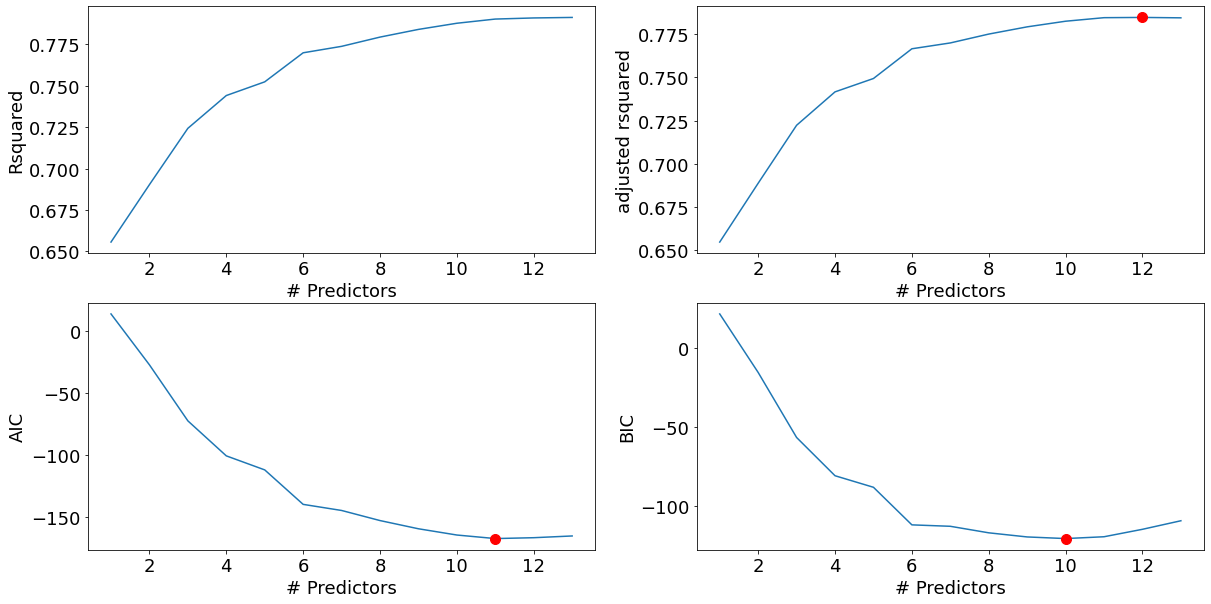

In [22]:
best_sub_plots()

In [23]:
best_bwd_reg_model = models_best['model'][10]
best_bwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(median_val)   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     146.2
Date:                Wed, 10 May 2023   Prob (F-statistic):          6.27e-126
Time:                        11:12:31   Log-Likelihood:                 93.210
No. Observations:                 405   AIC:                            -164.4
Df Residuals:                     394   BIC:                            -120.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.1706      0.228     18.269      0.000       3.722       4.619
crime_rate      -0.0109      0.002     -6.485      0.000      -0.014      -0.008
river            0.0985      0.037      2.627      0.009       0.025       0.172
nitric_oxide    -0.8390      0.156     -5.380      0.000      -1.146      -0.532
avg_rooms        0.0912      0.018      5.118      0.000       0.056       0.126
dist_emp        -0.0476      0.007     -6.449      0.000      -0.062      -0.033
highway_acc      0.0119      0.003      4.077      0.000       0.006       0.018
tax_rate        -0.0004      0.000     -2.867      0.004      -0.001      -0.000
pt_ratio        -0.0396      0.006     -7.127      0.000      -0.051      -0.029
race_prop        0.0004      0.000      2.840      0.005       0.000       0.001
low_inc         -0.0283      0.002    -13.455      0.000      -0.032      -0.024
==============================================================================
Omnibus:                       60.139   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              156.789
Skew:                           0.722   Prob(JB):                     8.99e-35
Kurtosis:                       5.684   Cond. No.                     1.45e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.45e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
#Finding the RMSE of the model selected using the backward selection procedure, where the predictors
#include 2-factor interactions
pred = np.exp(best_bwd_reg_model.predict(test))
print('Backward Stepwise Selection RMSE:', np.sqrt(((pred - test.median_val)**2).mean()))

Backward Stepwise Selection RMSE: 3.2487002208385203


## OVERALL

- Backward RMSE lower than Ridge and Lasso and Mars models
- Bagged Trees and Random forest have a lower RMSE than backward stepwise

# XGBoost
*By Emily Zhang

### coarse grid search

In [18]:
xgb = XGBRegressor(random_state=45)

# Coarse grid search 
param_grid = {'max_depth':[4,6,8],
              'n_estimators':[800, 1000, 1200], 
              'learning_rate':[0.1,0.25,0.5],
              'reg_lambda':[0,1,10],
              'gamma':[0,10],
              'subsample':[0.4,0.45,0.5]
             }

cv = KFold(n_splits=2, shuffle=True, random_state=1)
grid = RandomizedSearchCV(xgb, param_grid, n_jobs=-1,verbose=1,cv=cv, scoring='neg_mean_absolute_error', random_state = 45)
grid.fit(X_train, y_train)

print(grid.best_score_, grid.best_params_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
-2.318373927975645 {'subsample': 0.5, 'reg_lambda': 10, 'n_estimators': 1200, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 10}


In [19]:
# Print best hyperparameters
print("Best hyperparameters:", grid.best_params_)

# Compute RMSE on test data using best model from grid search
best_model = grid.best_estimator_
y_test_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("Test RMSE:", test_rmse)

Best hyperparameters: {'subsample': 0.5, 'reg_lambda': 10, 'n_estimators': 1200, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 10}
Test RMSE: 3.05080608751799


In [20]:
xgb = XGBRegressor(random_state=45)

# Coarse grid search 
param_grid = {'max_depth':[4,6,8],
              'n_estimators':[800, 1000, 1200], 
              'learning_rate':[0.1,0.25,0.5],
              'reg_lambda':[0,1,10],
              'gamma':[0,10],
              'subsample':[0.4,0.45,0.5]
             }

cv = KFold(n_splits=2, shuffle=True, random_state=1)
grid = RandomizedSearchCV(xgb, param_grid, n_jobs=-1,verbose=1,cv=cv, scoring='neg_mean_absolute_error', random_state = 1)
grid.fit(X_train, y_train)

print(grid.best_score_, grid.best_params_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
-2.291871967882213 {'subsample': 0.5, 'reg_lambda': 1, 'n_estimators': 1200, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 10}


In [21]:
# Print best hyperparameters
print("Best hyperparameters:", grid.best_params_)

# Compute RMSE on test data using best model from grid search
best_model = grid.best_estimator_
y_test_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("Test RMSE:", test_rmse)

Best hyperparameters: {'subsample': 0.5, 'reg_lambda': 1, 'n_estimators': 1200, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 10}
Test RMSE: 2.709290310082389


In [24]:
model = XGBRegressor(random_state = 1, max_depth = 8, learning_rate = 0.1,
                        n_estimators = 1200,reg_lambda = 1, gamma = 10, subsample = 0.5).fit(X_train, y_train)

y_pred = model.predict(X_test)

# Calculate the MAE on the test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("Test RMSE:", test_rmse)

Test RMSE: 2.709290310082389


In [25]:
# Get the feature importances from the best model
importances = model.feature_importances_

# Create a list of predictor names from the columns of X_train
predictor_names = X_train.columns.tolist()

# Get the indices that would sort the importances in descending order
sorted_indices = np.argsort(importances)[::-1]

# Print the predictors in decreasing order of importance
print("Predictors in decreasing order of importance:")
for index in sorted_indices:
    predictor_name = predictor_names[index]
    importance = importances[index]
    print(f"{predictor_name}: Importance {importance}")

Predictors in decreasing order of importance:
low_inc: Importance 0.2656997740268707
avg_rooms: Importance 0.25576847791671753
nitric_oxide: Importance 0.11697163432836533
dist_emp: Importance 0.07226280868053436
crime_rate: Importance 0.05165812745690346
prop_age: Importance 0.04226367548108101
pt_ratio: Importance 0.03911416977643967
tax_rate: Importance 0.0374554842710495
nr_business: Importance 0.031473543494939804
race_prop: Importance 0.026955164968967438
highway_acc: Importance 0.025546807795763016
river: Importance 0.018372390419244766
zoned_land: Importance 0.016457924619317055


## fine tuning

In [14]:
xgb = XGBRegressor(random_state=45)

# Coarse grid search 
param_grid = {'max_depth':[4,6,8,10],
              'n_estimators':[1000, 1200, 1400], 
              'learning_rate':[0.03, 0.05, 0.07, 0.1],
              'reg_lambda':[0,1,2],
              'gamma':[8, 9,10],
              'subsample':[0.45, 0.5, 0.55]
             }

cv = KFold(n_splits=2, shuffle=True, random_state=1)
grid = RandomizedSearchCV(xgb, param_grid, n_jobs=-1,verbose=1,cv=cv, scoring='neg_mean_absolute_error', random_state = 1)
grid.fit(X_train, y_train)

print(grid.best_score_, grid.best_params_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
-2.2011262579719615 {'subsample': 0.45, 'reg_lambda': 1, 'n_estimators': 1400, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 8}


In [15]:
# Print best hyperparameters
print("Best hyperparameters:", grid.best_params_)

# Compute RMSE on test data using best model from grid search
best_model = grid.best_estimator_
y_test_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("Test RMSE:", test_rmse)

Best hyperparameters: {'subsample': 0.45, 'reg_lambda': 1, 'n_estimators': 1400, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 8}
Test RMSE: 2.822496981169104
